In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -qq "/content/drive/MyDrive/dogs-vs-cats.zip"

In [7]:
!unzip -qq "/content/train.zip"

In [6]:
!unzip -qq "/content/test1.zip"

In [2]:
import tensorflow as tf
import numpy as np
import pandas as  pd
import os
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
seed = 13
tf.random.set_seed(seed)
np.random.seed(seed)

In [8]:
train_df = pd.DataFrame({"file": os.listdir("/content/train/")})
train_df["label"] = train_df["file"].apply(lambda x : x.split(".")[0])

train_df.head()

,file,label
0,cat.6362.jpg,cat
1,cat.723.jpg,cat
2,dog.8400.jpg,dog
3,dog.877.jpg,dog
4,dog.6744.jpg,dog


In [9]:
test_df = pd.DataFrame({"file": os.listdir("/content/test1/")})

test_df.head()

,file
0,4559.jpg
1,172.jpg
2,11644.jpg
3,4108.jpg
4,6715.jpg


In [10]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train_df,
                                        test_size =0.2,
                                        stratify=train_df["label"],
                                        random_state=13)

In [11]:
## 데이터 증강

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [13]:
Files = "/content/"
batch_size = 160
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = Files + "train/",
    x_col = "file",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224,224),
    batch_size = batch_size,
    seed =13
)

Found 20000 validated image filenames belonging to 2 classes.


In [14]:

val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = Files + "train/",
    x_col = "file",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224,224),
    batch_size = batch_size,
    seed =13,
    shuffle= False
)

Found 5000 validated image filenames belonging to 2 classes.


In [15]:
## FC는 포함하지 않겠다는 의미 >> include_top = False

In [16]:
base_model = VGG16(
    weights = "imagenet",
    input_shape = (224,224,3),
    include_top = False
)

58889256/58889256 [==============================] - 4s 0us/step


In [17]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
## 가중치가 학습되지 않도록 잠궈버리자
## 필터가 찾은 특징만 가져오는 설정
## 결국엔 하이퍼 파라미터 학습이 잘 안된다면 전에 layer까지 잠군다


In [19]:
for layers in base_model.layers:
    layers.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
## 모델 뒤에 붙이기

In [21]:
def vgg16_pretrained():
    model = Sequential(
        [
            base_model,
            GlobalAveragePooling2D(),
            Dense(100, activation="relu"),
            Dropout(0.4),
            Dense(64, activation="relu"),
            Dense(2, activation="softmax")
        ]
    )

    return model

In [22]:
tf.keras.backend.clear_session()

In [23]:
model = vgg16_pretrained()
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = "accuracy")


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                        

In [24]:
## 콜백 얼리 스타핑

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    patience = 5,
    verbose = 1,
    mode = "max",
)

In [27]:
## 모델 저장시 사용

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    monitor = "val_accuracy",
    filepath = "catdog_vgg16_.{epoch:02d}-{val_accuracy:.6f}.hdf5",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True

)

In [30]:
hist = model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = val_data.shape[0]//batch_size,
    steps_per_epoch = train_data.shape[0] // batch_size,
    callbacks = [early_stopping, checkpoint]
)

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.9262
Epoch 1: val_accuracy improved from -inf to 0.97802, saving model to catdog_vgg16_.01-0.978024.hdf5
125/125 [==============================] - 334s 2s/step - loss: 0.2738 - accuracy: 0.9262 - val_loss: 0.0581 - val_accuracy: 0.9780
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9693
Epoch 2: val_accuracy improved from 0.97802 to 0.98165, saving model to catdog_vgg16_.02-0.981653.hdf5
125/125 [==============================] - 325s 3s/step - loss: 0.0878 - accuracy: 0.9693 - val_loss: 0.0516 - val_accuracy: 0.9817
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9749
Epoch 3: val_accuracy improved from 0.98165 to 0.98367, saving model to catdog_vgg16_.03-0.983669.hdf5
125/125 [==============================] - 307s 2s/step - loss: 0.0670 - accuracy: 0.9749 - val_loss: 0.0474 - val_accuracy: 0.9837
Epoch 4/10

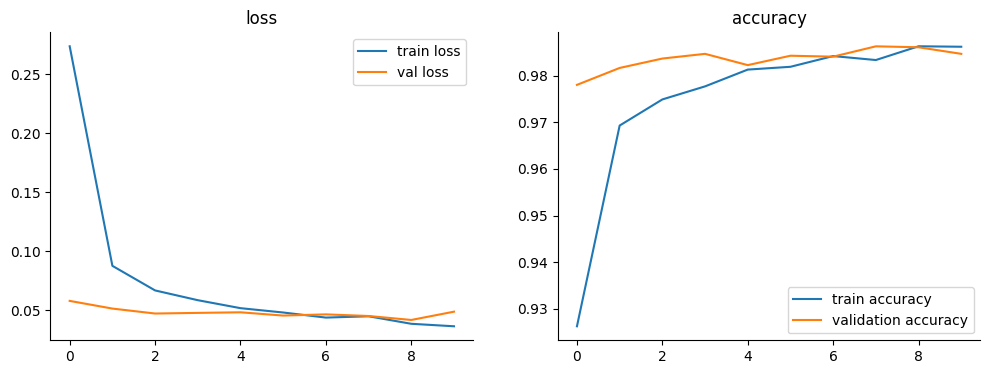

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.lineplot(x = range(len(hist.history["loss"])),
             y = hist.history["loss"], ax = axes[0],
             label = "train loss")

sns.lineplot(x = range(len(hist.history["loss"])),
             y = hist.history["val_loss"], ax = axes[0],
             label = "val loss")

sns.lineplot(x = range(len(hist.history["accuracy"])),
             y = hist.history["accuracy"], ax = axes[1],
             label = "train accuracy")

sns.lineplot(x = range(len(hist.history["accuracy"])),
             y = hist.history["val_accuracy"], ax = axes[1],
             label = "validation accuracy")

axes[0].set_title("loss")
axes[1].set_title("accuracy")

sns.despine()
plt.show()

In [34]:
val_pred = model.predict(val_generator,
                         steps = np.ceil(val_data.shape[0] / batch_size))

val_data.loc[:, "val_pred"] = np.argmax(val_pred, axis=1)

labels = dict((v,k) for k, v in val_generator.class_indices.items())

val_data.loc[:, "val_pred"] = val_data.loc[:, "val_pred"].map(labels)

32/32 [==============================] - 31s 966ms/step


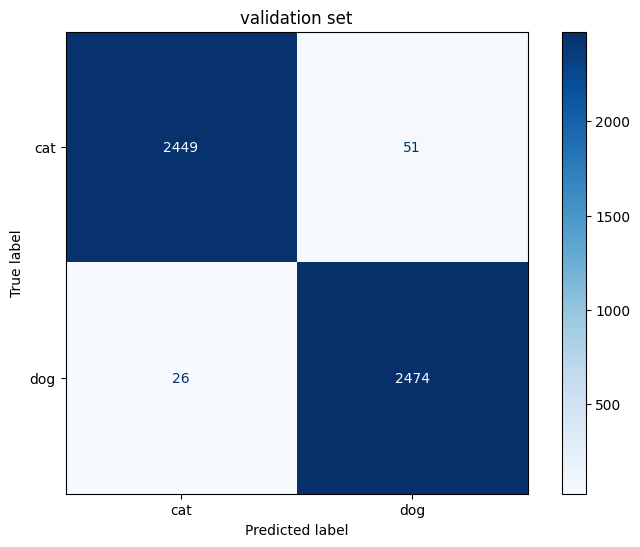

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(9,6))

cm = confusion_matrix(val_data["label"], val_data["val_pred"])

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = ["cat", "dog"])

disp.plot(cmap = plt.cm.Blues, ax =ax)

ax.set_title("validation set")
plt.show()

In [36]:
val_errors = val_data[(val_data.label) != (val_data.val_pred)].reset_index(drop = True)
val_errors

,file,label,val_pred
0,cat.7050.jpg,cat,dog
1,cat.5198.jpg,cat,dog
2,dog.3190.jpg,dog,cat
3,cat.9695.jpg,cat,dog
4,dog.6131.jpg,dog,cat
...,...,...,...
72,cat.11194.jpg,cat,dog
73,cat.11070.jpg,cat,dog
74,dog.10179.jpg,dog,cat
75,dog.7413.jpg,dog,cat


In [2]:
fig = plt.figure(1, figsize= (24,20))

for i in range(81):
    if i == len(val_errors):
        break

    plt.subplot(9, 9, i + 1)
    image = plt.imread("/content/train/" + val_errors.file[i])
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"True value : {val_errors['label'][i]} \n Prediction: {val_errors['val_pred'][i]}")


plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined